In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from utils import *

# Hounsield Units

First, we will hand select a region of interest for the different tissue/materials so we can calculate the slop and intercept for the HU values

In [23]:
from PIL import Image, ImageDraw

# Load the image
image_path = '../Data_Cropped_and_Resized/train/normal/10 (2) - Copy.png'
image = Image.open(image_path)

# Convert to grayscale
gray_image = image.convert('L')

# Find the brightest pixel
max_value = gray_image.getextrema()[1]
brightest_pixel = [coord for coord in zip(*np.where(np.array(gray_image) == max_value))][0]

# Define the region to highlight
highlight_size = 2
bone_left = max(brightest_pixel[1] - highlight_size, 0)
bone_top = max(brightest_pixel[0] - highlight_size, 0)
bone_right = min(brightest_pixel[1] + highlight_size, image.width - 1)
bone_bottom = min(brightest_pixel[0] + highlight_size, image.height - 1)

# Draw a rectangle around the brightest region
draw = ImageDraw.Draw(image)
draw.rectangle([bone_left, bone_top, bone_right, bone_bottom], outline='red')

# Display the image with the highlighted region
image.show()

In [24]:
image_path = '../Data_Cropped_and_Resized/train/normal/10 (2) - Copy.png'
image = Image.open(image_path)

# Convert to grayscale
gray_image = image.convert('L')

# Find the darkest pixel
min_value = gray_image.getextrema()[1]
brightest_pixel = [coord for coord in zip(*np.where(np.array(gray_image) == min_value))][0]

# Define the region to highlight (e.g., a 10x10 square around the darkest pixel)
highlight_size = 3
tissue_left = max(brightest_pixel[1] - highlight_size, 0)+15
tissue_top = max(brightest_pixel[0] - highlight_size, 0)+15
tissue_right = min(brightest_pixel[1] + highlight_size, image.width - 1)+15
tissue_bottom = min(brightest_pixel[0] + highlight_size, image.height - 1)+15

# Draw a rectangle around the darkest region
draw = ImageDraw.Draw(image)
draw.rectangle([tissue_left, tissue_top, tissue_right, tissue_bottom], outline='blue')  # Using blue for contrast

# Display the image with the highlighted region
image.show()

In [25]:
image_path = '../Data_Cropped_and_Resized/train/normal/10 (2) - Copy.png'
image = Image.open(image_path)

# Convert to grayscale
gray_image = image.convert('L')

# Find the darkest pixel
min_value = gray_image.getextrema()[1]
brightest_pixel = [coord for coord in zip(*np.where(np.array(gray_image) == min_value))][0]

# Define the region to highlight (e.g., a 10x10 square around the darkest pixel)
highlight_size = 3
air_left = max(brightest_pixel[1] - highlight_size, 0) -35
air_top = max(brightest_pixel[0] - highlight_size, 0)
air_right = min(brightest_pixel[1] + highlight_size, image.width - 1) -35
air_bottom = min(brightest_pixel[0] + highlight_size, image.height - 1)

# Draw a rectangle around the darkest region
draw = ImageDraw.Draw(image)
draw.rectangle([air_left, air_top, air_right, air_bottom], outline='blue')  # Using blue for contrast

# Display the image with the highlighted region
image.show()

In [27]:
image = cv2.imread('../Data_Cropped_and_Resized/train/normal/10 (2) - Copy.png', cv2.IMREAD_GRAYSCALE)

bone_pixel_values = image[bone_left:bone_right, bone_top:bone_bottom]
tissue_pixel_values = image[tissue_left:tissue_right, tissue_top:tissue_bottom]
air_pixel_values = image[air_left:air_right, air_top:air_bottom]

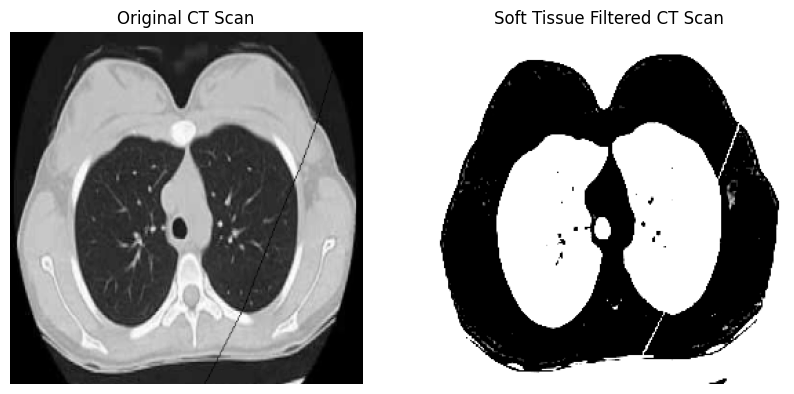

In [31]:
from scipy.stats import linregress

# Known Hounsfield Unit value of the material in the ROI (e.g., water is 0 HU)
bone_hu_value = 1500
tissue_hu_value = 40
air_hu_value = -1000

hu_values = [bone_hu_value, tissue_hu_value, air_hu_value]

# Calculate the average pixel intensity of the ROI
bone_average_pixel_intensity = np.mean(bone_pixel_values)
tissue_average_pixel_intensity = np.mean(tissue_pixel_values)
air_average_pixel_intensity = np.mean(air_pixel_values)

average_pixel_intensity = [bone_average_pixel_intensity, tissue_average_pixel_intensity, air_average_pixel_intensity]

# # Approximate the slope and intercept
# slope = known_hu_value / average_pixel_intensity
# intercept = 0

# Perform linear regression to estimate slope and intercept
slope, intercept, _, _, _ = linregress(average_pixel_intensity, hu_values)

# Apply Calibration and Conversion
hounsfield_units = slope * image + intercept

# Windowing and Visualization (Highlight Soft Tissue)
# Define the Hounsfield Unit range for soft tissue visualization
soft_tissue_lower = 30  # Choose the lower bound based on the soft tissue range
soft_tissue_upper = 60  # Choose the upper bound based on the soft tissue range

# Apply windowing to filter the soft tissue in the CT scan
windowed_image = np.clip(hounsfield_units, soft_tissue_lower, soft_tissue_upper)

# Normalize the windowed image to the range [0, 1] for visualization
windowed_image_normalized = (windowed_image - soft_tissue_lower) / (soft_tissue_upper - soft_tissue_lower)

# Display the original and windowed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original CT Scan')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(windowed_image_normalized, cmap='gray')
plt.title('Soft Tissue Filtered CT Scan')
plt.axis('off')

plt.show()

Let's try with just bounding the soft tissue and scaling to 0-255

In [53]:
def scale_value(X):
    original_min, original_max = (-1024, 3071)
    new_min, new_max = (0, 255)
    normalized_X = (X - original_min) / (original_max - original_min)
    scaled_X = normalized_X * (new_max - new_min) + new_min
    return scaled_X


def get_soft_tissue(img, class_label):
    soft_tissue_lower = scale_value(30)  # Choose the lower bound based on the soft tissue range
    soft_tissue_upper = scale_value(60)  # Choose the upper bound based on the soft tissue range

    # Apply windowing to filter the soft tissue in the CT scan
    windowed_image = np.clip(image, soft_tissue_lower, soft_tissue_upper)

    # Normalize the windowed image to the range [0, 1] for visualization
    windowed_image_normalized = (windowed_image - soft_tissue_lower) / (soft_tissue_upper - soft_tissue_lower)

    # Display the original and windowed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original CT Scan')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(windowed_image_normalized, cmap='gray')
    plt.title('Soft Tissue Filter')
    plt.axis('off')

    masked_img = image.copy()
    masked_img[windowed_image_normalized==0] = 1

    plt.subplot(1, 3, 3)
    plt.imshow(masked_img, cmap='gray')
    plt.title('Soft Tissue Filtered CT Scan')
    plt.axis('off')

    plt.suptitle(f'Class Label: {class_mappings[class_label]} ', fontsize=16)

    plt.show()
    return masked_img

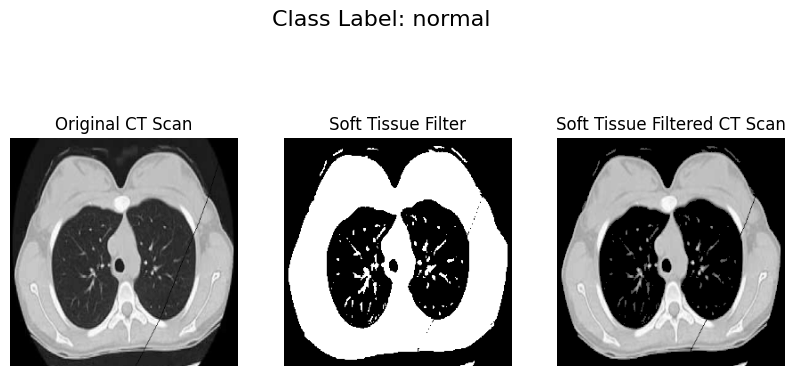

In [54]:
image = cv2.imread('../Data_Cropped_and_Resized/train/normal/10 (2) - Copy.png', cv2.IMREAD_GRAYSCALE)

masked_img = get_soft_tissue(image, 0)

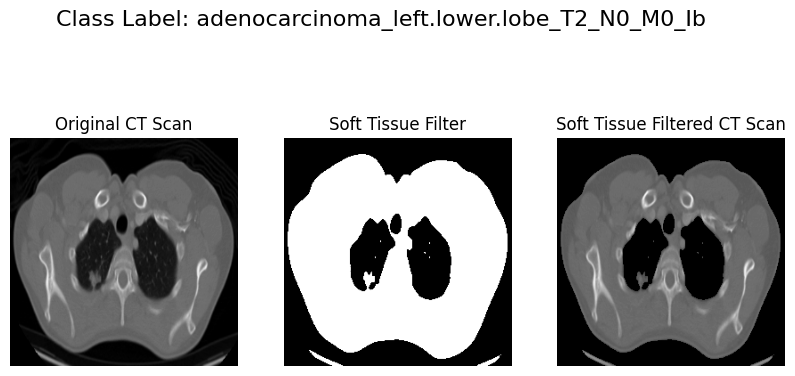

In [55]:
image = cv2.imread('../Data_Cropped_and_Resized/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000008 (10).png', cv2.IMREAD_GRAYSCALE)

masked_img = get_soft_tissue(image, 1)

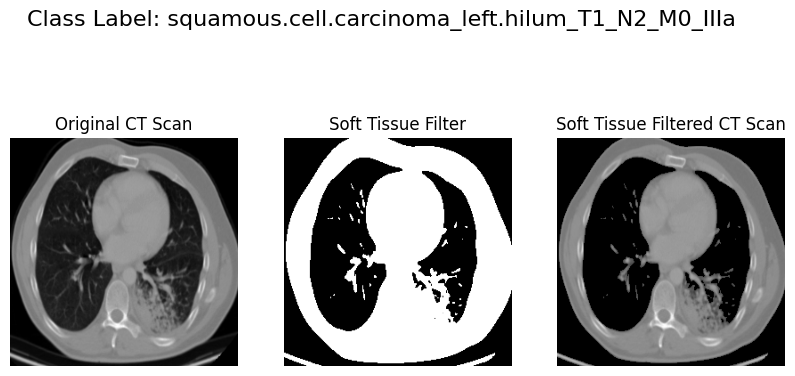

In [56]:
image = cv2.imread('../Data_Cropped_and_Resized/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000002 (4).png', cv2.IMREAD_GRAYSCALE)

masked_img = get_soft_tissue(image, 3)

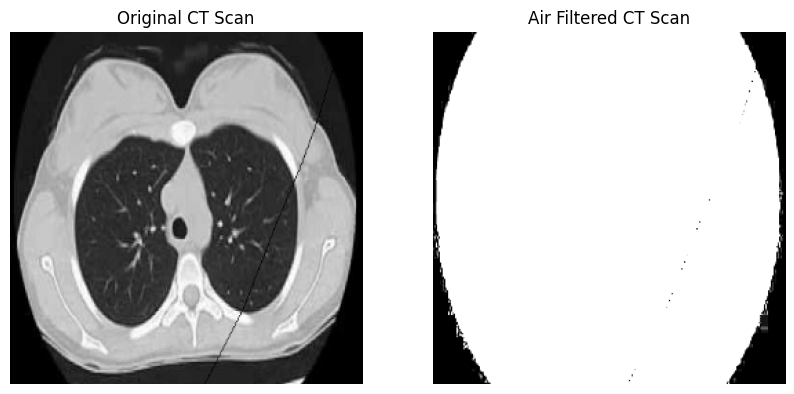

In [37]:
air_lower = scale_value(-1000)  # Choose the lower bound based on the soft tissue range
air_upper = scale_value(-900)  # Choose the upper bound based on the soft tissue range

# Apply windowing to filter the soft tissue in the CT scan
windowed_image = np.clip(image, air_lower, air_upper)

# Normalize the windowed image to the range [0, 1] for visualization
windowed_image_normalized = (windowed_image - air_lower) / (air_upper - air_lower)

# Display the original and windowed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original CT Scan')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(windowed_image_normalized, cmap='gray')
plt.title('Air Filtered CT Scan')
plt.axis('off')

plt.show()

# Simple thresholding

#### Simple threshold

In [2]:
data_dir = "../Data_Cropped_and_Resized"
train_path = f"{data_dir}/train"

train_imgs, train_thresh_edges, train_labels = extract_features(train_path, threshold_image)

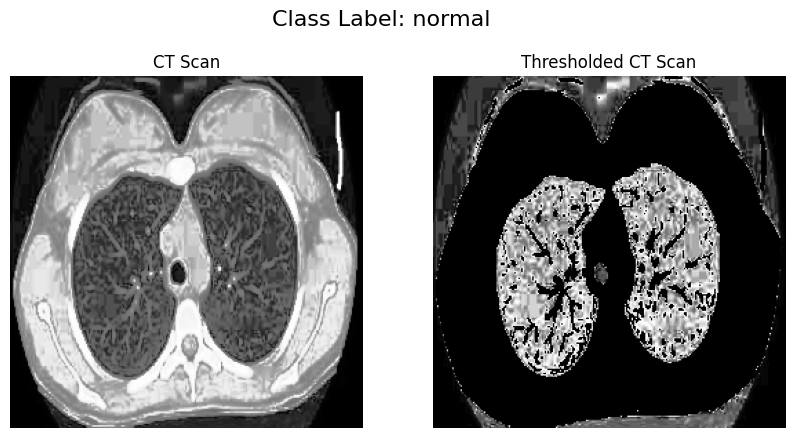

In [21]:
train_labels = np.array(train_labels)
label = 0
idxes, = np.where(train_labels == label)
i = idxes[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_imgs[i], cmap='gray')
plt.title(f'CT Scan')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(train_thresh_edges[i], cmap='gray')
plt.title('Thresholded CT Scan')
plt.axis('off')

plt.suptitle(f'Class Label: {class_mappings[label]} ', fontsize=16)

plt.show()

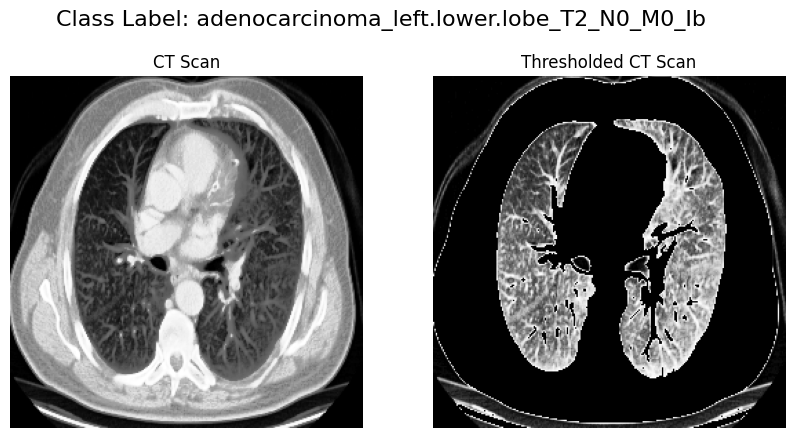

In [18]:
label = 1
idxes, = np.where(train_labels == label)
i = idxes[2]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_imgs[i], cmap='gray')
plt.title(f'CT Scan')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(train_thresh_edges[i], cmap='gray')
plt.title('Thresholded CT Scan')
plt.axis('off')

plt.suptitle(f'Class Label: {class_mappings[label]} ', fontsize=16)

plt.show()

#### Window slicing

In [20]:
def show_slice_window(slice, level, window):
   """
   Function to display an image slice
   Input is a numpy 2D array
   """
   max = level + window/2
   min = level - window/2
   slice = slice.clip(min,max)

   fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
  #  plt.figure()
   ax[0].imshow(slice, cmap="gray")

   retval, thresh_gray = cv2.threshold(slice, thresh=50, maxval=255, type=cv2.THRESH_BINARY)
   ax[1].imshow(thresh_gray, cmap='gray', vmin=0, vmax=255)
   return thresh_gray

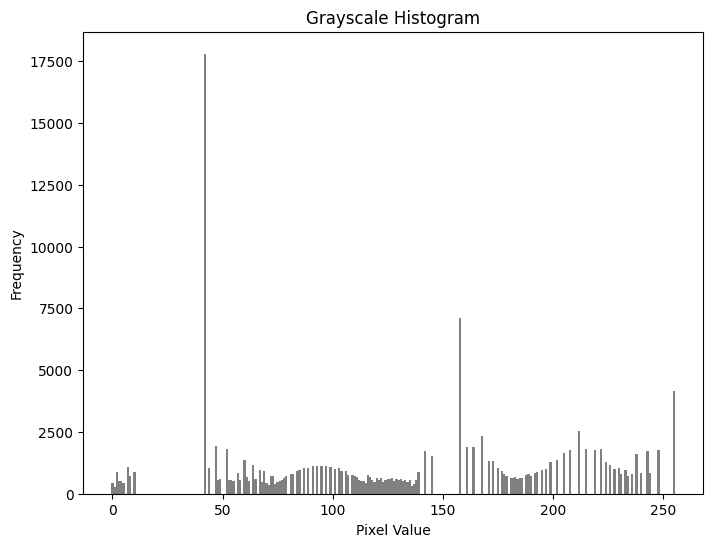

In [21]:
img_N = cv2.imread("../Data/train/normal/n9.jpg", cv2.IMREAD_GRAYSCALE)
img_N = cv2.equalizeHist(img_N)

# Calculate the histogram
hist, bins = np.histogram(img_N.flatten(), 256, [0, 256])

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(bins[:-1], hist, width=1, color='gray')
plt.title("Grayscale Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

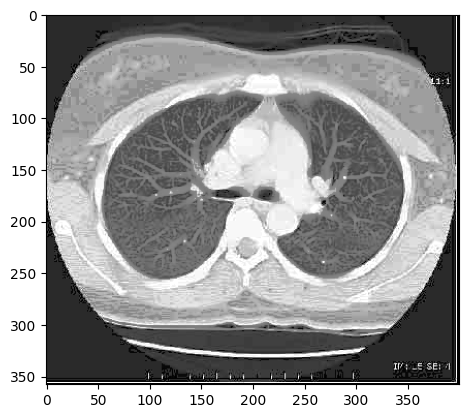

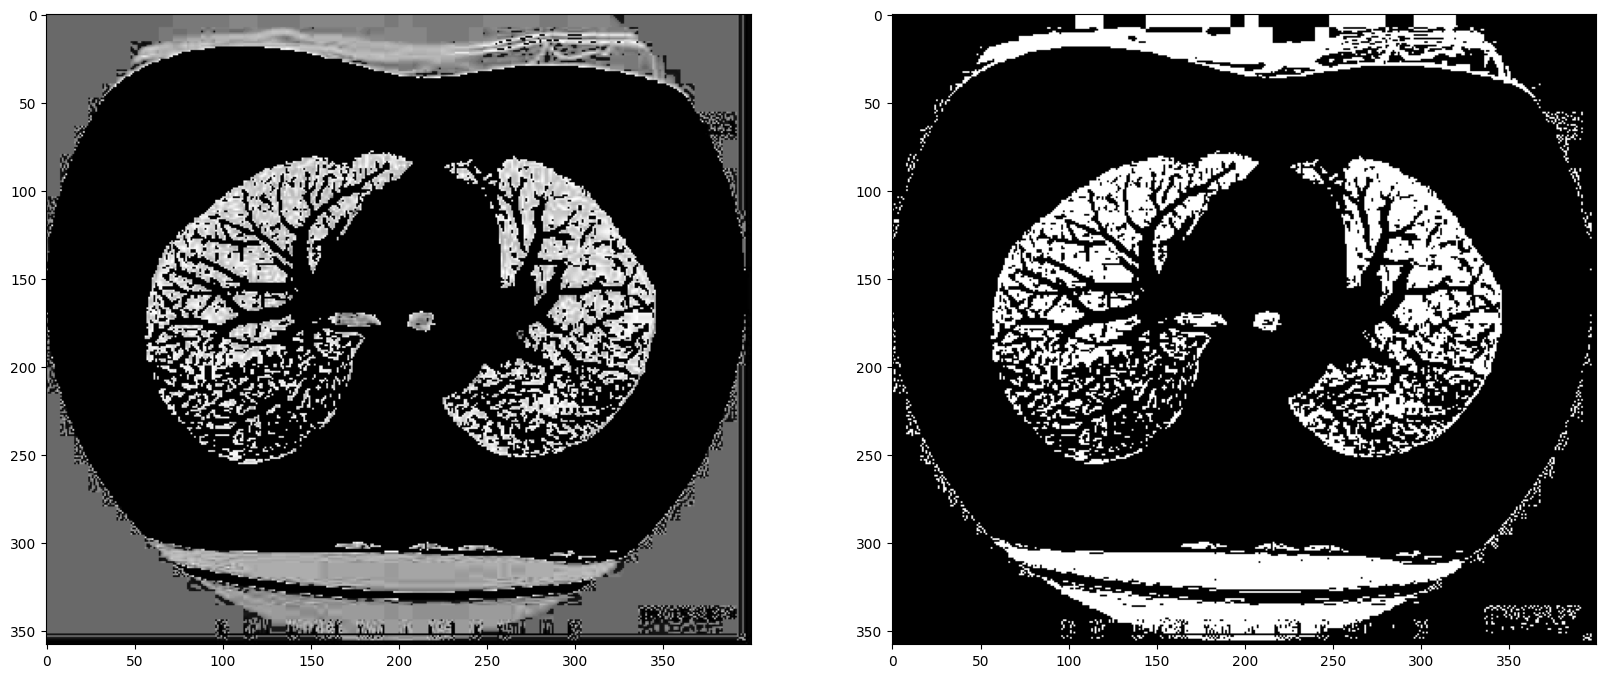

In [23]:
img_N_thresholded = cv2.equalizeHist(img_N)
img_N_thresholded[img_N_thresholded > 100] = 0

plt.imshow(img_N, cmap = "gray")
gray = show_slice_window(img_N_thresholded, -600, 1500)


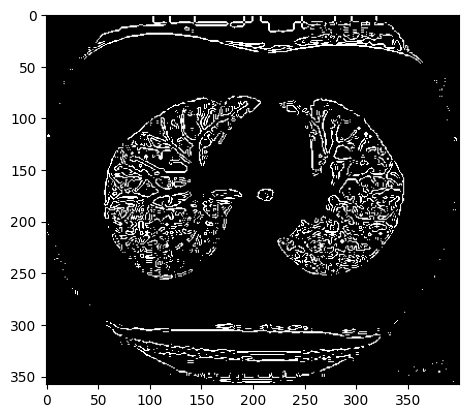

In [24]:
edges = detect_edges_sobel(gray, threshold = 200)
plt.imshow(edges, cmap = "gray")

In [7]:
def apply_hough_transform(img, param1=100, param2=30, minRadius=0, maxRadius=30):
  rows = img.shape[0]
  ### Parameters:
  # gray: Input image (grayscale).
  # circles: A vector that stores sets of 3 values: xc,yc,r for each detected circle.
  # HOUGH_GRADIENT: Define the detection method. Currently this is the only one available in OpenCV.
  # dp = 1: The inverse ratio of resolution.
  # min_dist = gray.rows/16: Minimum distance between detected centers.
  # param_1 = 200: Upper threshold for the internal Canny edge detector.
  # param_2 = 100*: Threshold for center detection.
  # min_radius = 0: Minimum radius to be detected. If unknown, put zero as default.
  # max_radius = 0: Maximum radius to be detected. If unknown, put zero as default.
  circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, rows / 8,
    param1=100, param2=30, minRadius=0, maxRadius=30)

  img_circles = img.copy()
  if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
      center = (i[0], i[1])
      # circle center
      # cv2.circle(img_circles, center, 1, (0, 100, 100), 3)
      # circle outline
      radius = i[2]
      cv2.circle(img_circles, center, radius, (0, 0, 255), 3)

  return img_circles

def blob_detection(image):
    # Initialize the SimpleBlobDetector parameters
    params = cv2.SimpleBlobDetector_Params()

    # Change parameters as needed
    params.minThreshold = 0
    params.maxThreshold = 200

    params.filterByArea = True
    params.minArea = 500
    # params.maxArea = 2000

    params.filterByCircularity = False
    params.minCircularity = 0.1;
    params.maxCircularity = 1e37;

    params.filterByInertia = False

    params.filterByConvexity = True
    params.minConvexity =  0.75

    # Create a SimpleBlobDetector object with the specified parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs in the image
    keypoints = detector.detect(image)

    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    fig, ax = plt.subplots(1,2,figsize=(10,10))
    ax[0].imshow(image, cmap='gray', vmin=0, vmax=255)
    ax[0].title.set_text('Origin')
    ax[1].imshow(im_with_keypoints, cmap='gray', vmin=0, vmax=255)
    ax[1].title.set_text('Blob')

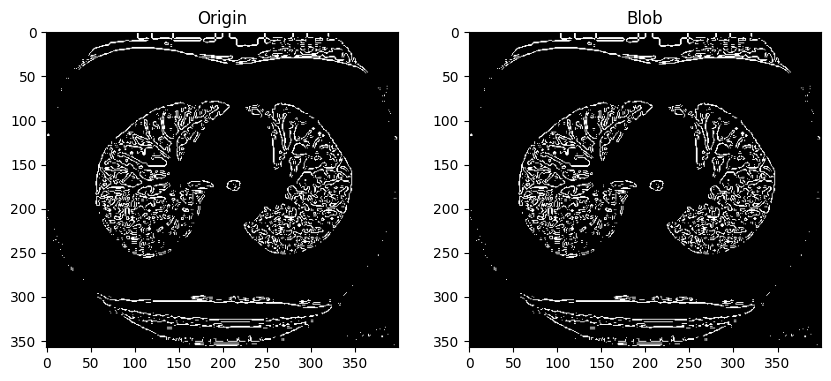

In [8]:
blob_detection(edges)

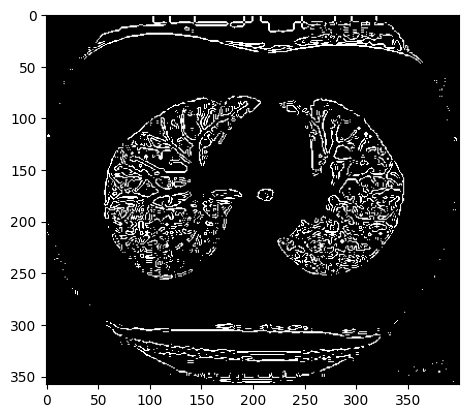

In [11]:
img_circles = apply_hough_transform(edges, minRadius=30)

plt.imshow(img_circles, cmap = "gray")

### Cancerous examples

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

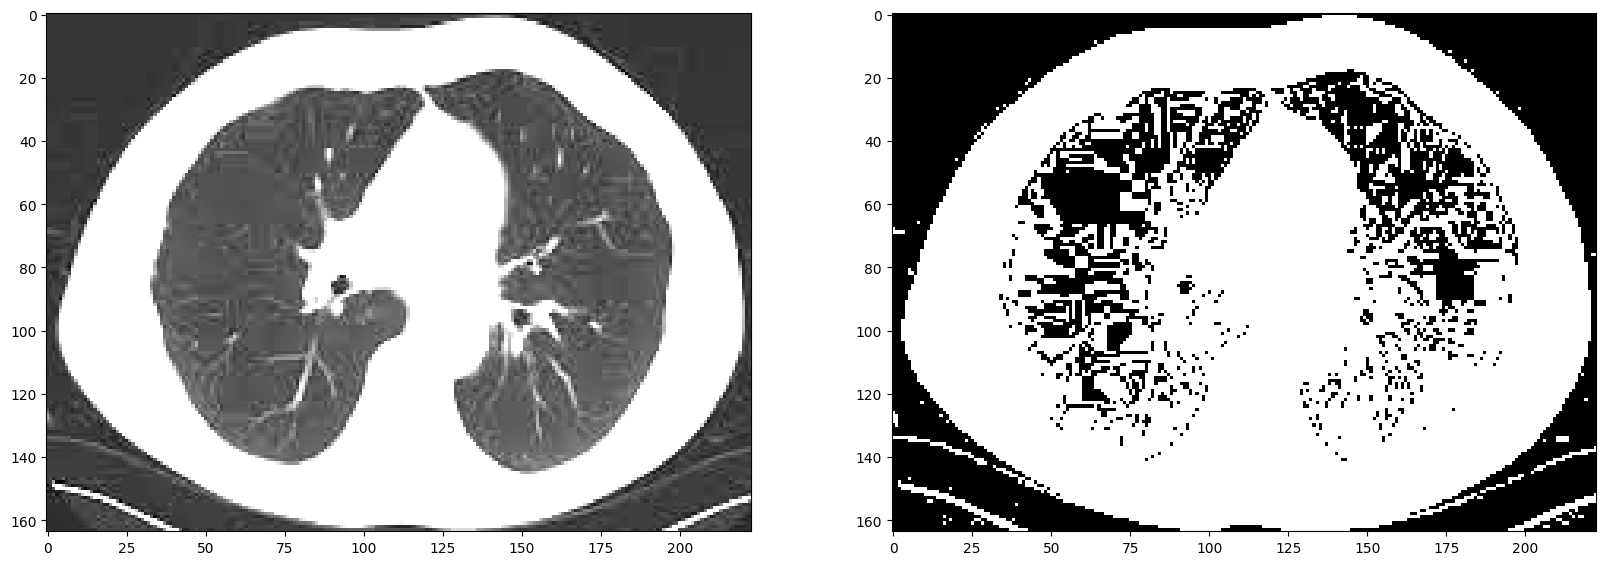

In [13]:
img_A = cv2.imread("../Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/ad22.png", cv2.IMREAD_GRAYSCALE)
# img_A = cv2.equalizeHist(img_A)

## LUNGS
show_slice_window(img_A, -600, 1500)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

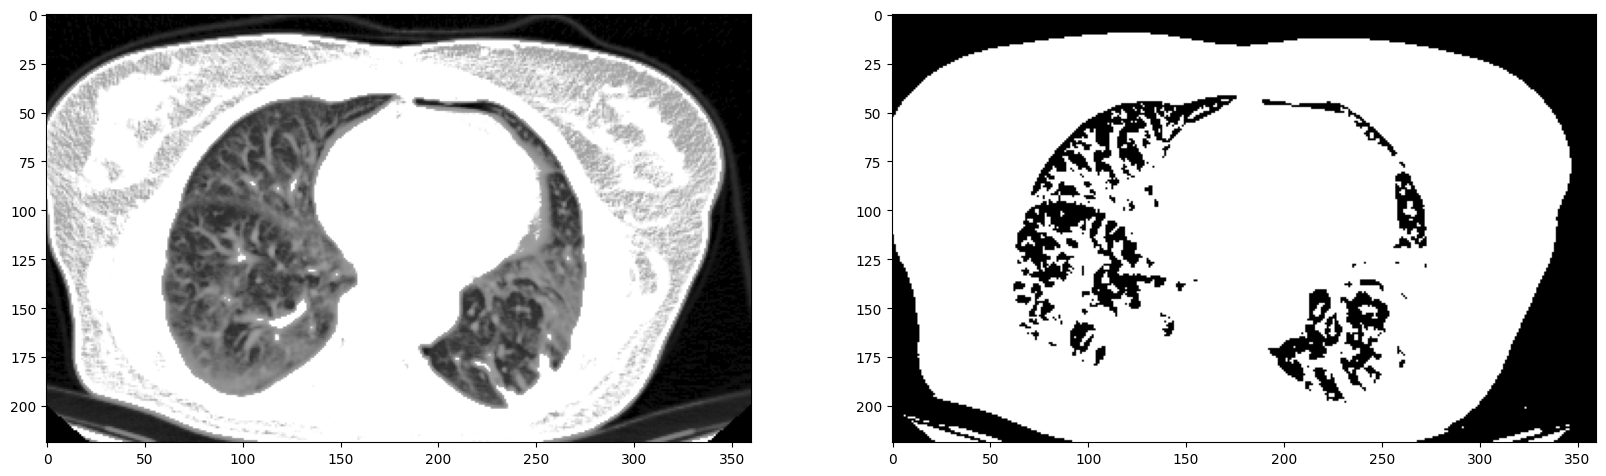

In [16]:
img_A2 = cv2.imread("../Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000122.png", cv2.IMREAD_GRAYSCALE)
img_A2= cv2.equalizeHist(img_A2)

show_slice_window(img_A2, -600, 1500)

array([[255.,   0., 255., ..., 255., 255., 255.],
       [255.,   0., 255., ..., 255., 255., 255.],
       [255.,   0., 255., ..., 255., 255., 255.],
       ...,
       [255.,   0.,   0., ...,   0.,   0.,   0.],
       [255.,   0.,   0., ...,   0.,   0.,   0.],
       [255.,   0.,   0., ...,   0.,   0.,   0.]])

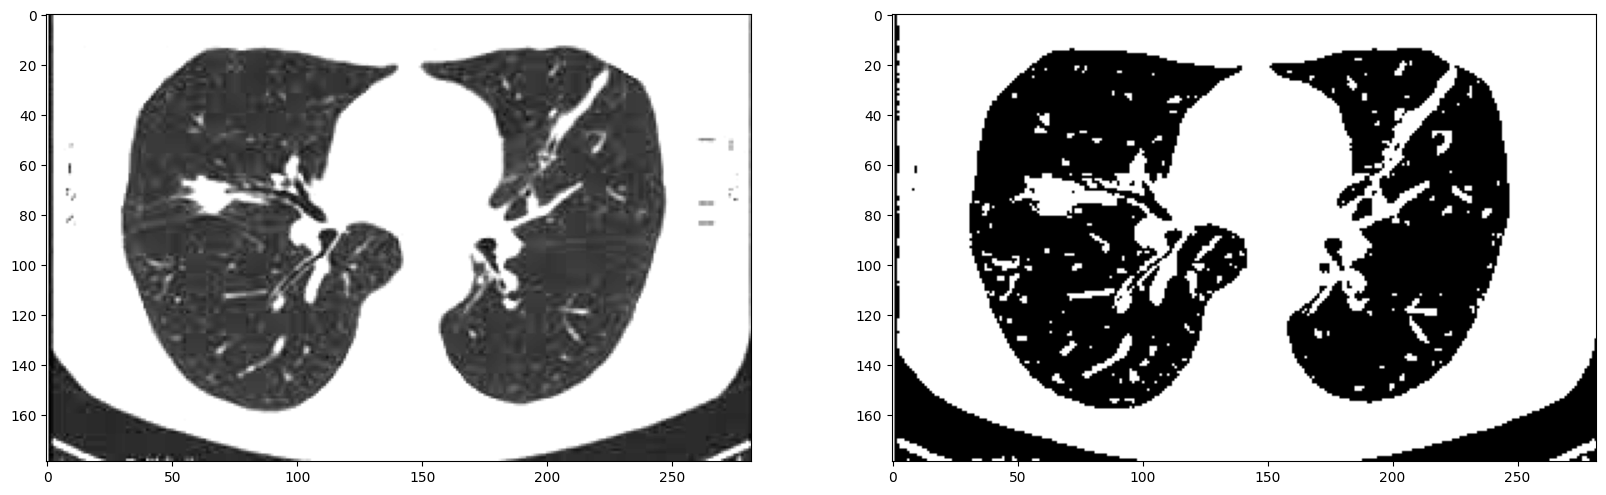

In [17]:
img_S = cv2.imread("../Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/sq6.png", cv2.IMREAD_GRAYSCALE)
# img_S = cv2.equalizeHist(img_S)

show_slice_window(img_S, -600, 1500)